Required Libraries

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

Download NLTK Stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load Dataset

In [3]:
file_path = "/content/Restaurant_Reviews 1.tsv"
df = pd.read_csv(file_path, sep="\t")

Initialize Porter Stemmer

In [4]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

Apply Preprocessing

In [5]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().strip()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [ps.stem(word) for word in words]
    return ' '.join(words)

df["Cleaned_Review"] = df["Review"].apply(preprocess_text)

Feature Extraction using TF-IDF

In [6]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df["Cleaned_Review"]).toarray()
y = df["Liked"]

Handle Class Imbalance

In [7]:
if len(set(y)) > 1 and np.bincount(y)[0] != np.bincount(y)[1]:
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

Split Data into Training and Testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Define Models with Optimized Hyperparameter Tuning

In [9]:
models = {
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1, 10]}),
    "Support Vector Machine": (SVC(), {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}),
    "Multinomial Naive Bayes": (MultinomialNB(), {"alpha": [0.1, 0.5, 1, 2]}),
    "Extra Trees Classifier": (ExtraTreesClassifier(), {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    })
}

best_model = None
best_accuracy = 0

Model Training and Selection

In [11]:
for name, (model, params) in models.items():
    try:
        grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}\n")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = grid_search.best_estimator_
    except Exception as e:
        print(f"Error occurred in {name}: {e}")

Logistic Regression Accuracy: 0.7650

Support Vector Machine Accuracy: 0.7900

Random Forest Accuracy: 0.7700

Gradient Boosting Accuracy: 0.7800

Multinomial Naive Bayes Accuracy: 0.7550

Extra Trees Classifier Accuracy: 0.8100



Display Best Model

In [12]:
print(f"\nBest Performing Model: {best_model.__class__.__name__} with Accuracy: {best_accuracy:.4f}")


Best Performing Model: ExtraTreesClassifier with Accuracy: 0.8100


Classification Report

In [13]:
y_pred_best = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.83      0.78      0.80       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



Plot Confusion Matrix

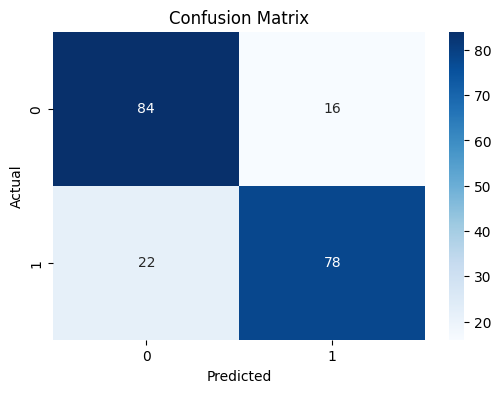

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Display TF-IDF Features

In [15]:
print("\nTop 10 TF-IDF Features:")
feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(tfidf.idf_)[::-1]
top_n = feature_array[tfidf_sorting][:10]
print(top_n)


Top 10 TF-IDF Features:
['opinion' 'carpaccio' 'carb' 'maintain' 'magic' 'magazin' 'madison'
 'madhous' 'macaron' 'mac']
